# Retrieving ECCO datasets when working in the AWS Cloud

## Introduction
Previous tutorials have discussed how to download ECCO datasets from PO.DAAC to your local machine. However, during 2021-2022 PO.DAAC datasets (including ECCO) migrated to the NASA Earthdata Cloud hosted by Amazon Web Services (AWS). While data downloads from the cloud (using wget, curl, Python requests, etc.) function like downloads from any other website, there are definite advantages to working with datasets within the cloud environment. Data can be opened in an S3 bucket and viewed without downloading, or can be quickly downloaded to a user's cloud instance for computations. For more information on PO.DAAC datasets in the cloud, there are [a number of infographics here](https://podaac.jpl.nasa.gov/cloud-datasets/about).

This tutorial will walk through the steps of how a user can set up an AWS instance and access ECCO datasets for computations in that instance. No prior experience with the AWS cloud is assumed.

## Set up an AWS cloud instance
Computations in the AWS Cloud are typically done in an Amazon Elastic Compute Cloud (EC2) instance, which is a self-contained computing environment like the operating system on your local machine. You start an EC2 instance through the AWS Cloud management console, then connect to the instance (e.g., through `ssh`) like you would to any other machine, install the software that you need, and start working. AWS offers a [Free Tier](https://aws.amazon.com/ec2/?did=ft_card&trk=ft_card) that provides 750 compute hours per month, 1 GB memory, and up to 30 GB storage for a period of 12 months. This is great for experimenting, but these memory/storage limits can be quite restrictive, so if you have institutional or project support for larger instances it is highly recommended to use them.

The steps here mostly follow this [excellent tutorial on the PO.DAAC Cookbook](https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html). 

### Step 1: Create an AWS account
If you don't already have one, [create an account on AWS](https://portal.aws.amazon.com/billing/signup#/start/email). Anyone with an e-mail address and a credit card can do this, though for the reasons above it is recommended that you seek out institutional support if possible, or include cloud computing costs in your grant proposals.

### Step 2: Start an EC2 instance
Once you log in to your new account, you should be at a screen with the title Console Home. First, let's make sure you are in the most optimal AWS "region" for accessing PO.DAAC datasets, which are hosted in region *us-west-2 (Oregon)*. In the upper-right corner of the page just to the left of your username, there is a drop-down menu with a place name on it. Select the **US West (Oregon)    us-west-2** region.

Now let's start a new EC2 instance. Click on **Services** in the upper-left corner next to the AWS logo, then **Compute** --> **EC2**. On this new screen where there are a number of boxes, select the yellow **Launch instance** button. There are some settings on this screen to configure before launching the new instance:

*Name and tags*: Whatever you want (e.g., ECCO tutorials).

*Application and OS images (Amazon Machine Image)*: **Quick Start** --> **Red Hat** --> **Red Hat Enterprise Linux 9, SSD Volume Type**
This is not the only AMI you can use, and your institution may have preferred or required AMIs to use AWS cloud services. Make sure that the AMI you select runs Linux, and is "Free tier eligible" if you are not supported by your institution or project.

*Instance type*: **t2.micro** if using the Free tier. If you're not restricted to the free tier, **t2.medium** or larger is recommended.

*Key pair (login)*: Click on **Create new key pair**. In the pop-up window, make the name whatever you want (e.g., aws_ec2_jupyter), select *Key pair type*: **RSA** and *Private key file format*: **.pem**, then **Create key pair**. This downloads the private key file to your Downloads folder, and you should move it to your `.ssh` folder: `mv ~/Downloads/aws_ec2_jupyter.pem ~/.ssh/`. Then change the permissions to read-only for the file owner `chmod 400 ~/.ssh/aws_ec2_jupyter.pem`.

*Network settings*: Your institution may have existing security groups that you should use, so click the **Select existing security group** and check with your IT or cloud support to see if there are recommended security groups/VPCs to use. If not or you are doing this on your own, then click **Create security group**, which will create a new security group with a name like *launch-wizard-1*. Make sure that the boxes to allow HTTPS and HTTP traffic from the internet are checked.

*Configure storage*: Specify a storage volume with at least **15 GiB gp3** as your root volume. This is important, since the pyython/conda installation with the packages we need will occupy ~7.5 GB, and we need some workspace as a buffer. If you are in Free tier then you can request up to 30 GB across all your instances, so you can use up the full amount in a single instance or split it across two instances with 15 GB each.

*Advanced details*: Depending on your security/institutional requirements, you may need to include a specific IAM profile. Check the *IAM instance profile* dropdown menu to see if there is one associated with your security group.

Finally, at the bottom-right of the page click the yellow **Launch instance** button. Wait a minute or two for the instance to initialize; you can check the **Instances** screen accessed from the menu on the left side to see that your Instance state is **Running**.

### Step 3: Install software and set up conda environment

Since your instance starts with a very bare-bones Linux OS, you will need to install software (conda/miniconda/miniforge) to run Python, and then install Python packages and the Jupyter interface to run these tutorial notebooks. A shell script to expedite this process is provided on the tutorial Github page, and here we will walk through setting this up.

First, ssh into your new instance. For most users this will be at the public IPv4 address on the AWS instance summary page, e.g., if the IP address is 35.24.135.171, then: 

```
ssh -i "~/.ssh/aws_ec2_jupyter.pem" ec2-user@35.24.135.171 -L 9889:localhost:9889
```

Some users with an institutional network or VPN might use the private IP address instead. The `-L` option indicates a tunnel from the local machine's port 9889 to the instance's port 9889; this will be used later to open Jupyterlab through your local machine's web browser.

> Tip: If you are having difficulty connecting to your new instance, you might need to change your network/security group settings to allow SSH traffic from your local machine and/or HTTPS/HTTP traffic. Alternatively, you may need to [attach an IAM role to your instance](https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/iam-roles-for-amazon-ec2.html).

Now we will update the OS on the instance and install `git` so that we can clone the [ECCOv4 Python tutorial repository](https://github.com/ECCO-GROUP/ECCO-v4-Python-Tutorial). This repository includes a shell script that can be used to finish setting up our workspace. First run the following commands on the instance:

```
sudo dnf update -y
sudo dnf install git -y
cd ~
git clone https://github.com/ECCO-GROUP/ECCO-v4-Python-Tutorial.git
```

Now we will execute a shell script that will set up a conda environment called `jupyter`, allow the user to input their NASA Earthdata username and password (which are written to the `~/.netrc` file on the instance), and open up Jupyter lab on the instance.

```
sudo chmod 755 ~/ECCO-v4-Python-Tutorial/ECCO-ACCESS/Cloud_access_to_ECCO_datasets/jupyter_env_setup.sh
~/ECCO-v4-Python-Tutorial/ECCO-ACCESS/Cloud_access_to_ECCO_datasets/jupyter_env_setup.sh
```

The script takes a few minutes to run, but it should set up our environment with the packages we need, even within the memory constraints of a free-tier t2.micro instance. After this is done (and while still connected to your instance through port 9889), open up a window in your local machine's web browser and put ``http://127.0.0.1:9889/`` in the URL field. A Jupyter lab should open up in the ECCOv4 tutorial notebook directory, with notebooks ready to run!


## The *ecco_s3_retrieve* module

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from ecco_s3_retrieve import *
import time

## with no parallelization (1 process, 1 thread)

In [2]:
%%time
file_list = ecco_podaac_s3_open(ShortName="ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4",\
                                StartDate="2010-01",EndDate="2010-12")

{'ShortName': 'ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4', 'temporal': '2010-01-02,2010-12-31'}

Total number of matching granules: 12
CPU times: user 470 ms, sys: 79.8 ms, total: 550 ms
Wall time: 2.76 s


In [3]:
%%time
ds = xr.open_mfdataset(file_list,\
                       data_vars='minimal',coords='minimal',\
                       compat='override',\
                       chunks={'time':1,'k':50,'tile':13,'j':90,'i':90})
ds

CPU times: user 4.4 s, sys: 1.11 s, total: 5.51 s
Wall time: 11.1 s


<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, tile: 13, time: 12, nv: 2, nb: 4)
Coordinates: (12/13)
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 2010-01-16T12:00:00 ... 2010-12-16T12:00:00
    ...         ...
    YC         (tile, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG         (tile, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    SSH        (time, tile, j, i) float32 dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    SSHIBC     (time, tile, j, i) float32 dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    SSHNOIBC   (time, tile, j, i) float32 dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    ETAN       (time, tile, j, i) float32 dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            2010-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          2010-01-01T00:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean llc9...
    uuid:                         9ce7afa6-400c-11eb-ab45-0cc47a3f49c3

In [6]:
grid_file = ecco_podaac_s3_open(ShortName="ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                                    StartDate="1992-01",EndDate="2017-12")
ds_grid = xr.open_dataset(grid_file)
ds_grid

{'ShortName': 'ECCO_L4_GEOMETRY_LLC0090GRID_V4R4', 'temporal': '1992-01-01,2017-12-31'}

Total number of matching granules: 1


<xarray.Dataset>
Dimensions:  (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
              k_p1: 51, tile: 13, nb: 4, nv: 2)
Coordinates: (12/20)
  * i        (i) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * k_u      (k_u) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...       ...
    Zp1      (k_p1) float32 ...
    Zu       (k_u) float32 ...
    Zl       (k_l) float32 ...
    XC_bnds  (tile, j, i, nb) float32 ...
    YC_bnds  (tile, j, i, nb) float32 ...
    Z_bnds   (k, nv) float32 ...
Dimensions without coordinates: nb, nv
Data variables: (12/21)
    CS       (tile, j, i) float32 ...
    SN       (tile, j, i) float32 ...
    rA       (tile, j, i) float32 ...
    dxG      (tile, j_g, i) float32 ...
    dyG      (tile, j, i_g) float32 ...
    Depth    (tile, j, i) float32 ...
    ...       ...
    hFacC    (k, tile, j, i) float32 ...
    hFacW    (k, tile, j, i_g) float32 ...
    hFacS    (k, tile, j_g, i) float32 ...
    maskC    (k, tile, j, i) bool ...
    maskW    (k, tile, j, i_g) bool ...
    maskS    (k, tile, j_g, i) bool ...
Attributes: (12/58)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    references:                      ECCO Consortium, Fukumori, I., Wang, O.,...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters for the Lat-Lon...
    uuid:                            87ff7d24-86e5-11eb-9c5f-f8f21e2ee3e0

In [7]:
%%time
cell_vol = ds_grid.hFacC*ds_grid.rA*ds_grid.drF
cell_vol = cell_vol.compute()

CPU times: user 135 ms, sys: 22.8 ms, total: 157 ms
Wall time: 158 ms


In [8]:
%%time
total_vol = cell_vol.sum().compute()
theta_global_mean = (cell_vol*ds.THETA).sum(dim=["k","tile","j","i"])/\
                        total_vol

CPU times: user 304 ms, sys: 18.6 ms, total: 323 ms
Wall time: 326 ms


CPU times: user 2.27 s, sys: 365 ms, total: 2.63 s
Wall time: 3.4 s


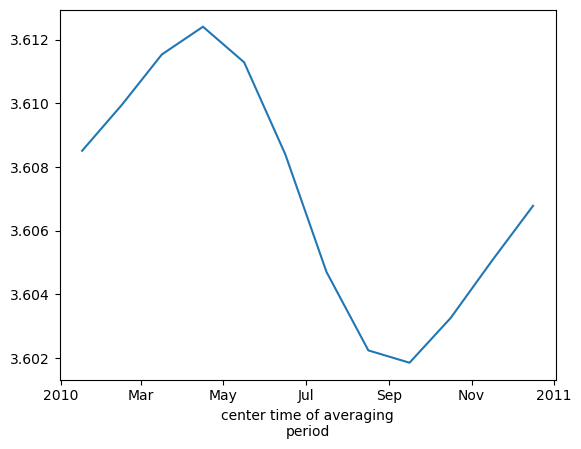

In [9]:
%%time
theta_global_mean = theta_global_mean.compute()
theta_global_mean.plot()

## Using 2 processes and threads

In [4]:
from distributed import Client
client = Client("127.0.0.1:46381")
print(client)

<Client: 'tcp://127.0.0.1:46381' processes=2 threads=2, memory=7.50 GiB>


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import s3fs

In [3]:
# Initialize s3 client with s3fs
%time fs = s3fs.S3FileSystem(anon=True)

# Open with s3fs
%time f = fs.open("s3://noaa-goes16/ABI-L2-MCMIPM/2021/241/14/OR_ABI-L2-MCMIPM1-M6_G16_s20212411400278_e20212411400347_c20212411400421.nc")

# open xarray dataset
%time data = xr.open_dataset(f, engine='h5netcdf')
%time data = data.compute()

CPU times: user 42 µs, sys: 9 µs, total: 51 µs
Wall time: 62.7 µs
CPU times: user 5.16 ms, sys: 4.84 ms, total: 10 ms
Wall time: 321 ms
CPU times: user 1.08 s, sys: 125 ms, total: 1.2 s
Wall time: 5.69 s
CPU times: user 477 ms, sys: 93.8 ms, total: 570 ms
Wall time: 2.36 s


In [11]:
data

<xarray.Dataset>
Dimensions:                                 (y: 500, x: 500,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/37)
    t                                       datetime64[ns] ...
  * y                                       (y) float64 0.09349 ... 0.06555
  * x                                       (x) float64 -0.04981 ... -0.02187
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C11                             (band) int8 ...
    band_id_C12                             (band) int8 ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    ...                                      ...
    mean_brightness_temperature_C16         float32 ...
    std_dev_brightness_temperature_C16      float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    dynamic_algorithm_input_data_container  int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2021-08-29T14:00:42.1Z
    time_coverage_start:       2021-08-29T14:00:27.8Z
    time_coverage_end:         2021-08-29T14:00:34.7Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        e59f8226-334f-4494-8263-79cc5f2fb878

In [7]:
%%time
file_list = ecco_podaac_s3_open(ShortName="ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4",\
                                StartDate="2010-01",EndDate="2010-12")

{'ShortName': 'ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4', 'temporal': '2010-01-02,2010-12-31'}

Total number of matching granules: 12
CPU times: user 222 ms, sys: 46.5 ms, total: 268 ms
Wall time: 47.9 s


In [6]:
%%time
ds = xr.open_mfdataset(file_list,\
                       data_vars='minimal',coords='minimal',\
                       compat='override',parallel=True,\
                       chunks={'time':1,'k':50,'tile':13,'j':90,'i':90})
ds

CPU times: user 138 ms, sys: 105 ms, total: 243 ms
Wall time: 24.2 s


<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
                k_p1: 51, tile: 13, time: 12, nv: 2, nb: 4)
Coordinates: (12/22)
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k          (k) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...         ...
    Zu         (k_u) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zl         (k_l) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    Z_bnds     (k, nv) float32 dask.array<chunksize=(50, 2), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    THETA      (time, k, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    SALT       (time, k, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
Attributes: (12/62)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               2010-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             2010-01-01T00:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            f4291248-4181-11eb-82cd-0cc47a3f446d

In [5]:
grid_file = ecco_podaac_s3_open(ShortName="ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                                    StartDate="1992-01",EndDate="2017-12")
ds_grid = xr.open_dataset(grid_file)
ds_grid

{'ShortName': 'ECCO_L4_GEOMETRY_LLC0090GRID_V4R4', 'temporal': '1992-01-01,2017-12-31'}

Total number of matching granules: 1


<xarray.Dataset>
Dimensions:  (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
              k_p1: 51, tile: 13, nb: 4, nv: 2)
Coordinates: (12/20)
  * i        (i) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * k_u      (k_u) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...       ...
    Zp1      (k_p1) float32 ...
    Zu       (k_u) float32 ...
    Zl       (k_l) float32 ...
    XC_bnds  (tile, j, i, nb) float32 ...
    YC_bnds  (tile, j, i, nb) float32 ...
    Z_bnds   (k, nv) float32 ...
Dimensions without coordinates: nb, nv
Data variables: (12/21)
    CS       (tile, j, i) float32 ...
    SN       (tile, j, i) float32 ...
    rA       (tile, j, i) float32 ...
    dxG      (tile, j_g, i) float32 ...
    dyG      (tile, j, i_g) float32 ...
    Depth    (tile, j, i) float32 ...
    ...       ...
    hFacC    (k, tile, j, i) float32 ...
    hFacW    (k, tile, j, i_g) float32 ...
    hFacS    (k, tile, j_g, i) float32 ...
    maskC    (k, tile, j, i) bool ...
    maskW    (k, tile, j, i_g) bool ...
    maskS    (k, tile, j_g, i) bool ...
Attributes: (12/58)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    references:                      ECCO Consortium, Fukumori, I., Wang, O.,...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters for the Lat-Lon...
    uuid:                            87ff7d24-86e5-11eb-9c5f-f8f21e2ee3e0

In [6]:
%%time
cell_vol = ds_grid.hFacC*ds_grid.rA*ds_grid.drF
cell_vol = cell_vol.compute()

CPU times: user 137 ms, sys: 21.2 ms, total: 158 ms
Wall time: 164 ms


In [7]:
%%time
total_vol = cell_vol.sum().compute()
theta_global_mean = (cell_vol*ds.THETA).sum(dim=["k","tile","j","i"])/\
                        total_vol

CPU times: user 155 ms, sys: 10.8 ms, total: 166 ms
Wall time: 8.44 s


/home/jpluser/miniforge3/envs/pangeo/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 80.12 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 145 ms, sys: 74.1 ms, total: 219 ms
Wall time: 18.2 s


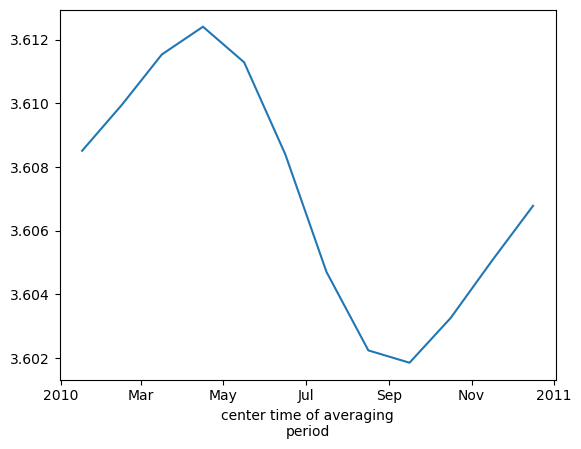

In [8]:
%%time
theta_global_mean = theta_global_mean.compute()
theta_global_mean.plot()

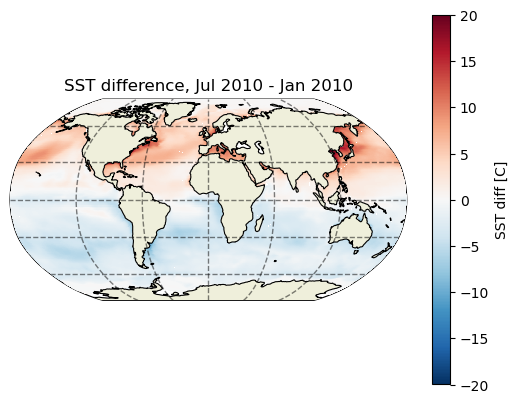

In [5]:
import ecco_v4_py as ecco

ecco.plot_proj_to_latlon_grid(\
                              ds.XC,ds.YC,ds.THETA.isel(k=0,time=[0,6]).diff("time"),\
                              cmin=-20,cmax=20,\
                              show_colorbar=True,colorbar_label='SST diff [C]')
plt.title('SST difference, Jul 2010 - Jan 2010')
plt.show()